Đây là một thuật toán phân cụm mạnh mẽ, không cần chọn số cụm K trước, và cho bạn toàn bộ quá trình gộp cụm dưới dạng cây (dendrogram) — cực kỳ trực quan và linh hoạt!

Mình sẽ trình bày theo đúng phong cách bạn yêu thích:

🔹 1. Nguyên lý hoạt động (không công thức nặng!)
🎯 Mục tiêu:
Xây dựng một cây phân cấp (dendrogram) thể hiện quá trình gộp các điểm/cụm lại với nhau, từ mỗi điểm là một cụm → đến toàn bộ dữ liệu là một cụm.

🧠 Ý tưởng chính — “Gộp dần từ dưới lên, như cây phả hệ!”
Có hai cách tiếp cận, nhưng phổ biến nhất là:

Agglomerative (từ dưới lên) — bottom-up
Mỗi điểm là một cụm riêng (n điểm → n cụm).
Lặp lại:
Tìm hai cụm gần nhất
Gộp chúng thành một cụm mới
Dừng khi chỉ còn 1 cụm (hoặc khi đạt số cụm mong muốn).
🔍 Làm sao đo “khoảng cách giữa hai cụm”?
Single linkage: khoảng cách = gần nhất giữa 2 điểm ở 2 cụm.
Complete linkage: khoảng cách = xa nhất.
Average linkage: khoảng cách = trung bình tất cả cặp điểm. ← Phổ biến nhất
Ward linkage: gộp sao cho tổng phương sai trong cụm tăng ít nhất. ← Rất tốt, thường dùng
💡 Ưu điểm của dendrogram:
Bạn không cần chọn K trước!
Sau khi có cây, bạn cắt ngang ở độ cao bất kỳ → ra số cụm mong muốn.
Rất trực quan, giúp hiểu cấu trúc dữ liệu.
✅ Ưu điểm:
Không cần chọn K ban đầu.
Kết quả ổn định, không ngẫu nhiên như K-Means.
Dendrogram giúp khám phá dữ liệu.
❌ Hạn chế:
Chậm với dữ liệu lớn (độ phức tạp ~O(n³) hoặc O(n² log n)).
Không cập nhật được khi có dữ liệu mới (phải chạy lại từ đầu).
Khó xử lý nhiễu (mọi điểm đều được gộp, không có "nhiễu" như DBSCAN).


🔹 3. Khi nào dùng Hierarchical Clustering?
Dữ liệu
nhỏ đến trung bình
(< 10k điểm)
Dữ liệu
rất lớn
→ quá chậm
Bạn muốn
khám phá cấu trúc phân cấp
của dữ liệu
Cần
cập nhật cụm khi có dữ liệu mới
Không biết K
, nhưng muốn
thử nhiều K dễ dàng
(chỉ cần cắt dendrogram)
Dữ liệu có
nhiễu mạnh
→ mọi điểm đều được gộp
Phân tích
sinh học, xã hội học, tài liệu
(nơi cấu trúc phân cấp tự nhiên)
Cần
tốc độ cao
trong production

🎯 So sánh nhanh 3 thuật toán phân cụm:
Cần chọn K?
✅ Có
❌ Không
❌ Không (cắt sau)
Phát hiện nhiễu?
❌ Không
✅ Có
❌ Không
Hình dạng cụm
Chỉ hình cầu
✅ Bất kỳ
Tốt với linkage phù hợp
Tốc độ
⚡ Rất nhanh
🐢 Trung bình
🐌 Chậm
Kết quả ổn định?
❌ (ngẫu nhiên)
✅ Có
✅ Có
Trực quan
Trung bình
Tốt
✅✅
Dendrogram rất trực quan

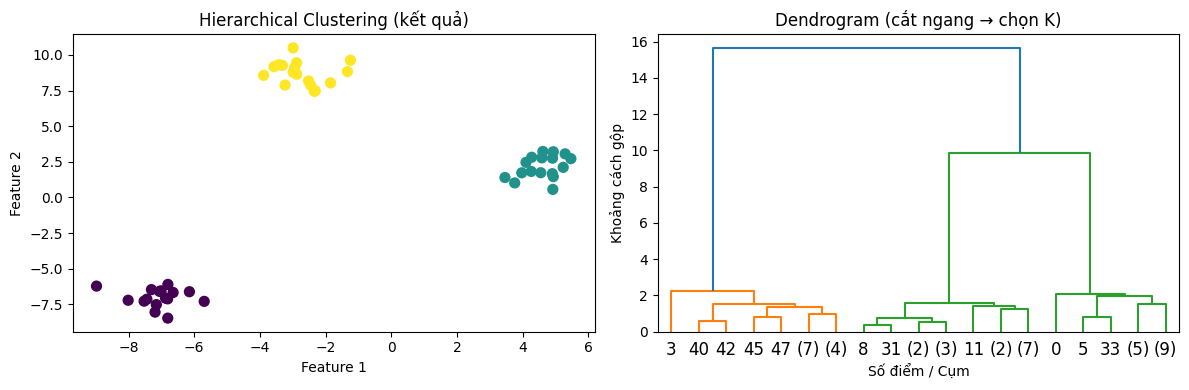

✅ Hierarchical Clustering đã chạy!
🔍 Số cụm tìm được: 3


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

class SimpleHierarchicalClustering:
    def __init__(self, n_clusters=2, linkage='average'):
        self.n_clusters = n_clusters
        self.linkage = linkage

    def _compute_cluster_distance(self, X, cluster1, cluster2):
        """Tính khoảng cách trung bình giữa hai cụm"""
        dists = []
        for i in cluster1:
            for j in cluster2:
                dist = np.linalg.norm(X[i] - X[j])
                dists.append(dist)
        return np.mean(dists)

    def fit(self, X):
        n_samples = len(X)
        # Mỗi điểm là một cụm
        clusters = [[i] for i in range(n_samples)]
        self.history = []  # lưu lịch sử gộp để vẽ dendrogram (nếu cần)

        # Lặp đến khi chỉ còn 1 cụm
        while len(clusters) > 1:
            min_dist = float('inf')
            merge_i, merge_j = -1, -1

            # Tìm hai cụm gần nhất
            for i in range(len(clusters)):
                for j in range(i + 1, len(clusters)):
                    dist = self._compute_cluster_distance(X, clusters[i], clusters[j])
                    if dist < min_dist:
                        min_dist = dist
                        merge_i, merge_j = i, j

            # Gộp hai cụm
            new_cluster = clusters[merge_i] + clusters[merge_j]
            # Xóa cụm lớn trước để không lệch index
            del clusters[max(merge_i, merge_j)]
            del clusters[min(merge_i, merge_j)]
            clusters.append(new_cluster)
            self.history.append((min_dist, len(clusters)))

        # Sau khi có toàn bộ cây, cắt để lấy n_clusters
        self.clusters_ = clusters  # nhưng chưa đủ — cần lưu lịch sử đầy đủ để cắt đúng

        # 👉 Trong thực tế, ta dùng scipy/sklearn để có dendrogram hoàn chỉnh
        from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
        self.linkage_matrix = linkage(X, method=self.linkage)
        self.labels_ = fcluster(self.linkage_matrix, self.n_clusters, criterion='maxclust')

    def fit_predict(self, X):
        self.fit(X)
        return self.labels_

# --- Thử nghiệm ---
from sklearn.datasets import make_blobs

# Tạo dữ liệu
X, _ = make_blobs(n_samples=50, centers=3, cluster_std=0.8, random_state=42)

# Huấn luyện Hierarchical Clustering
hc = SimpleHierarchicalClustering(n_clusters=3, linkage='average')
labels = hc.fit_predict(X)

# Vẽ kết quả phân cụm
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=50)
plt.title("Hierarchical Clustering (kết quả)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

# Vẽ dendrogram (dùng scipy)
from scipy.cluster.hierarchy import dendrogram, linkage
plt.subplot(1, 2, 2)
linked = linkage(X, method='average')
dendrogram(linked, truncate_mode='level', p=4)
plt.title("Dendrogram (cắt ngang → chọn K)")
plt.xlabel("Số điểm / Cụm")
plt.ylabel("Khoảng cách gộp")

plt.tight_layout()
plt.show()

print("✅ Hierarchical Clustering đã chạy!")
print(f"🔍 Số cụm tìm được: {len(np.unique(labels))}")